In [58]:
import pandas as pd
import numpy as np
import xlrd
from datetime import datetime

In [21]:
def clean_vic_df(age_file):
    
    # print(f'{age_file}')
    
    df = pd.read_csv(f'sources/raw/{age_file}.csv')
    
    # drop unneeded columns
    df.drop(['Active_Cases', 'Daily_Recovered', 'Cases', 'Sex'], axis=1, inplace=True)

    # reorder columns
    df = df[['Date', 'agegroup', 'Cases_Male', 'Cases_Female']]

    # convert date strings to python datetime objects
    df['Date'] = pd.to_datetime(df['Date'])

    # retain only dates from 1/1/22 to 4/4/22
    start_date = datetime(2022, 1, 1)
    end_date = datetime(2022, 4, 8)

    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    # print(f'Rows after dates selected = {df.shape[0]}')

    # combine duplicate dates; add male and female cases
    df = df.groupby('Date').sum()
    df['Cases'] = df['Cases_Male'] + df['Cases_Female']

    # print(f'Rows after duplicate dates combined = {df.shape[0]}')

    # drop male and female cases; no longer needed
    df.drop(['Cases_Male', 'Cases_Female'], axis=1, inplace=True)
    
    df = df.astype("int")

    # rename column to age range
    df.columns = [age_file]
        
    df.to_csv(f'sources/clean/{age_file}.csv')
    return df

In [22]:
age_files = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

df_vic = pd.DataFrame()

for file in age_files:
    df_vic = pd.concat([df_vic, clean_vic_df(file)], axis=1)
        
print(f'Expected rows: 98 | Actual rows: {df_vic.shape[0]}')
df_vic.head()

Expected rows: 98 | Actual rows: 98


,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90+
Date,,,,,,,,,,
2022-01-01,389,705,2784,1406,605,608,342,180,58,13
2022-01-02,459,828,3294,1682,800,743,395,174,88,19
2022-01-03,654,1470,5372,2626,1263,1274,640,261,134,32
2022-01-04,805,1992,7046,3025,1628,1421,793,301,98,33
2022-01-05,776,2676,9464,3827,1863,1715,878,342,96,26


In [52]:
# bring in population stats
df_pop = pd.read_csv('sources/raw/abs_population.csv')

# rename columns
df_pop.rename(columns={
    "Unnamed: 0": "state_terr",
    "Population at 30 Sep 2021 ('000)": "population x1000"
    },
    inplace=True)

# drop columns
df_pop = df_pop[['state_terr', 'population x1000']]

# drop rows
df_pop.drop([8, 9, 10], inplace=True)

# set state_terr to index
df_pop.set_index('state_terr', inplace=True)

df_pop

,population x1000
state_terr,
New South Wales,8186.8
Victoria,6643.1
Queensland,5240.5
South Australia,1772.8
Western Australia,2685.2
Tasmania,540.8
Northern Territory,245.9
Australian Capital Territory,430.5


In [48]:
# bring in qld cases

df_qld = pd.read_csv('sources/raw/qld_all_ages.csv')

# rename columns
df_qld.columns = ['date', 'age_group']

# convert date strings into datetime objects
df_qld['date'] = pd.to_datetime(df_qld['date'], infer_datetime_format=True)

# collect age groups belonging to each date
# add up age group totals for every day
# unstack - make age groups their own columns
df_qld = df_qld.groupby(['date']).value_counts().unstack()

# retain only dates from 1/1/22 to 4/4/22
start = datetime(2022, 1, 1)
end = datetime(2022, 4, 1)

df_qld = df_qld[start:end]

# create list of original age groups to drop later
orig_age_groups = df_qld.columns.values

# replace NaN with 0
df_qld = df_qld.replace(np.nan, 0)

# combine age groups to match vic
df_qld['0-9'] = df_qld['00-04 years'] + df_qld['05-09 years']
df_qld['10-19'] = df_qld['10-14 years'] + df_qld['15-19 years']
df_qld['20-29'] = df_qld['20-24 years'] + df_qld['25-29 years']
df_qld['30-39'] = df_qld['30-34 years'] + df_qld['35-39 years']
df_qld['40-49'] = df_qld['40-44 years'] + df_qld['45-49 years']
df_qld['50-59'] = df_qld['50-54 years'] + df_qld['55-59 years']
df_qld['60-69'] = df_qld['60-64 years'] + df_qld['65-69 years']
df_qld['70-79'] = df_qld['70-74 years'] + df_qld['75-79 years']
df_qld['80-89'] = df_qld['80-84 years'] + df_qld['85-89 years']
df_qld['90+'] = df_qld['90-94 years'] + df_qld['95-99 years']

df_qld.drop(orig_age_groups, axis=1, inplace=True)

df_qld = df_qld.astype("int")

df_qld

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90+
date,,,,,,,,,,
2022-01-01,206,490,1621,874,555,428,225,104,48,11
2022-01-02,241,744,2254,945,570,463,246,115,37,9
2022-01-03,331,1253,3882,1552,912,675,332,129,52,7
2022-01-04,379,1602,4982,2077,1112,848,373,130,57,13
2022-01-05,380,1686,5382,2208,1298,928,401,159,47,16
...,...,...,...,...,...,...,...,...,...,...
2022-03-28,381,591,379,455,501,315,190,80,44,16
2022-03-29,394,627,472,597,528,389,222,124,54,15
2022-03-30,424,646,547,690,637,407,251,114,65,20


In [20]:
# Q1 What percentage of new cases at start of term were children? 
# and what percentage of new cases at end of term were children?

start = '2022-01-31'
end = '2022-04-08'

df_term = df_vic.loc[start:end]

all_start = df_term.loc[start].sum()
child_start = df_term.loc[start, '0-9'] + df_term.loc[start, '10-19']
percent_start = round(child_start/all_start * 100)
print(all_start, child_start, percent_start)

all_end = df_vic.loc[start].sum()
child_end = df_vic.loc[end, '0-9'] + df_vic.loc[end, '10-19']
percent_end = round(child_end/all_end * 100)
print(all_end, child_end, percent_end)

11106 3584 32
9348 2390 26


Age group with most cases throughout term: 10-19
Number of cases in 10-19 group: 113696


<AxesSubplot:>

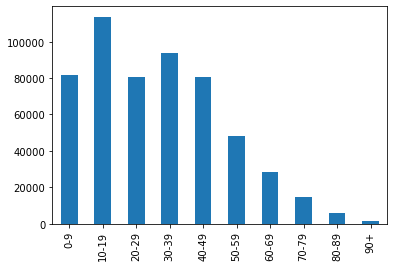

In [14]:
# Q2 Which age group had the most new cases throughout the term?
# answer: calc, illustrate with graph (bar)

age_group_max = df_term.sum().idxmax()
max_cases = df_term.sum().max()

print(f'Age group with most cases throughout term: {age_group_max}')
print(f'Number of cases in {age_group_max} group: {max_cases}')

df_term.sum().plot(kind='bar')

In [60]:
# Q3 How did case numbers compare to population proportion throughout term?
# answer: graph1 showing ratio of cases to age group population, for all age groups
# graph2 showing % of cases above population % line, for just children

df = pd.read_excel('sources/raw/abs.xls')
df

,Australian Bureau of Statistics,Unnamed: 1,Unnamed: 2
0,"Regional population by age and sex, 2020",NaN,NaN
1,Released at 11.30am (Canberra time) 27 August ...,NaN,NaN
2,NaN,NaN,NaN
3,"Population estimates by age and sex, by Statis...",NaN,NaN
4,NaN,NaN,NaN
5,NaN,Contents,NaN
6,NaN,Tables,NaN
7,NaN,1,"Estimated resident population by age, Statisti..."
8,NaN,2,"Estimated resident population by age, Statisti..."
9,NaN,3,"Estimated resident population by age, Statisti..."
